<a href="https://colab.research.google.com/github/akashsinghsharma/Retail-Sales-Prediction/blob/main/Retail_Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is going to be a Data Analaysis and Machine learning project. I will use python to answer multiple question that the stakeholder might ask, and ML to predict the sales for next 6 weeks in advance.


**Problem Description**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

In [1]:
pip install pyforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=fbcad434bd319f3bd90638f9d49f2ebc4032d60794d324f95bb8f01545afc087
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


In [2]:
import pyforest

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
rossmann_store_data = '/content/drive/MyDrive/Colab Notebooks/Data/Rossmann Stores Data.csv'
store_data = '/content/drive/MyDrive/Colab Notebooks/Data/store.csv'

sales_df = pd.read_csv(rossmann_store_data)
store_df = pd.read_csv(store_data)

<IPython.core.display.Javascript object>

<ipython-input-4-e73d6ed20dca>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv(rossmann_store_data)


<IPython.core.display.Javascript object>

In [5]:
sales_df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [31]:
store_df.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [7]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
sales_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

At first, let's clean the data. As we have seen in the above results, there are a number of null rows in different columns. I will go to them one by one.

CompetitionDistance column have 3 null rows. Let's see those rows.

In [12]:
store_df[store_df['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-26-6ef33948fab9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = store_df['CompetitionDistance'], hist = True)


<Axes: title={'center': 'Distribution of distance of competition from store'}, xlabel='Distance of competition', ylabel='Density'>

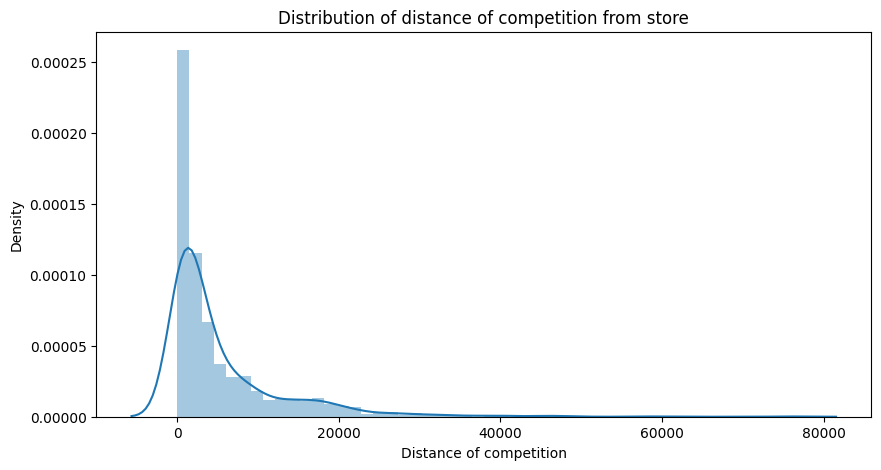

In [26]:
plt.figure(figsize = (10,5))
plt.xlabel('Distance of competition')
plt.title('Distribution of distance of competition from store')
sns.distplot(x = store_df['CompetitionDistance'], hist = True)

From the above viz, it's clear that the data is skew-ed right. As mdeian is more robust to outliers, I replace null values of this columnswith median.

In [27]:
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)

In [29]:
#Let's see if there is any rows with null value in above column remaining.

store_df[store_df['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [30]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Handling competitionopensincemonth and competitionopensinceyear column, as both are similar. First one store tells about month when the competition came in buisness and second tells about the year for the same. There are 354 null values in that column, thus I will replace them by Mode.

In [36]:
store_df['CompetitionOpenSinceMonth'].fillna(store_df['CompetitionOpenSinceMonth'].mode()[0], inplace = True)
store_df['CompetitionOpenSinceYear'].fillna(store_df['CompetitionOpenSinceYear'].mode()[0], inplace = True)

In [37]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Handling - Promo2SinceWeek, Promo2SinceYear, PromoInterval: This columns talk about if a store is participating in promotion or not. After talking to management and observing dataframe, it is clear that column where promo2 have 0, i.e. store is not participating in any promotion have null in columns above. We can simply replace those rows with 0.

In [39]:
store_df['Promo2SinceWeek'].fillna(value = 0 , inplace = True)
store_df['Promo2SinceYear'].fillna(value = 0 , inplace = True)
store_df['PromoInterval'].fillna(value = 0 , inplace = True)

Thus, all the null values are handled in each row.

Merging both dataframe now.